# 1 The objective of this notebook is to analyze the data from the dataset and get it ready for training

Data Description:

* Y = target attribute (Y) with values indicating 0 (unhappy) and 1 (happy) customers
* X1 = my order was delivered on time
* X2 = contents of my order was as I expected
* X3 = I ordered everything I wanted to order
* X4 = I paid a good price for my order
* X5 = I am satisfied with my courier
* X6 = the app makes ordering easy for me

Attributes X1 to X6 indicate the responses for each question and have values from 1 to 5 where the smaller number indicates less and the higher number indicates more towards the answer.

In [26]:
#---------Importing libraries---------#

#---Data analysis---#
import pandas as pd
import numpy as np


#---Data visualization---#
import matplotlib.pyplot as plt
import seaborn as sns

#---Data preprocessing---#
from sklearn.preprocessing import StandardScaler

#---utils---#
import os



## 1.1 data information

In [27]:
#---------Importing data---------#
df = pd.read_csv('../data/raw/ACME-HappinessSurvey2020.csv', sep=',')
df.head()

,Y,X1,X2,X3,X4,X5,X6
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5


In [28]:
# Checking the data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Y       126 non-null    int64
 1   X1      126 non-null    int64
 2   X2      126 non-null    int64
 3   X3      126 non-null    int64
 4   X4      126 non-null    int64
 5   X5      126 non-null    int64
 6   X6      126 non-null    int64
dtypes: int64(7)
memory usage: 7.0 KB


We now know that our dataset have 126 entrys and 5 columns, all of then are the int type.

Note: We are not transforming it from numerical to categorical because we know that the difference between each level is equal. This approach may work if the ordinal values truly reflect a consistent and meaningful ordering, and the assumption of equal spacing between levels is reasonable for your data.

## 1.2 data balance

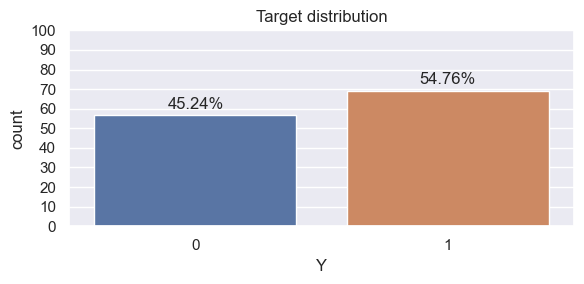

In [29]:
#checking if the target is balanced
plt.figure(figsize=(6,3))
sns.countplot(data=df, x='Y')
# Plotting % the values on top of each bar
for p in plt.gca().patches:
    plt.gca().annotate('{:.2f}%'.format(p.get_height() / len(df) * 100),
                       (p.get_x() + p.get_width() / 2, 1.05*p.get_height()),
                       ha='center')
plt.title('Target distribution')

#increasing the y ticks
plt.yticks(np.arange(0, 110, 10))
plt.tight_layout()

plt.show()

In [30]:
df.value_counts('Y', normalize=True)

Y
1    0.547619
0    0.452381
dtype: float64

## Data outliers

Target variable seens balanced, we will not need to balance it with for example SMOTE or undersample or oversample.

We know that there is not any missing values, lets check if the range of data for each feature is indeed the expected 1 - 5. With boxplots on default settings, where wiskers goes to 1.5* IQR, we can also see that there are some outliers.

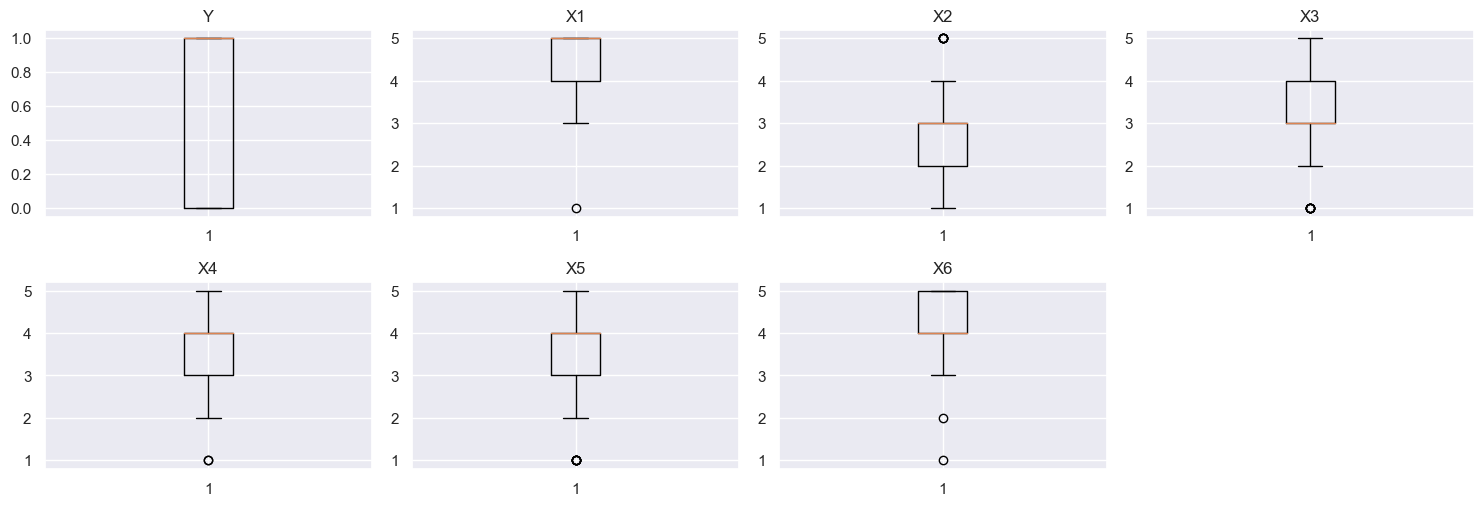

In [31]:
# checking trough the boxplots
plt.figure(figsize=(15,10))

for i, col in enumerate(df.columns):
    plt.subplot(4, 4, i+1, title=col)
    plt.boxplot(df[col])
    plt.tight_layout()


Okay, the data has the expected range. 

## 1.3 Correlation matrix

<Axes: >

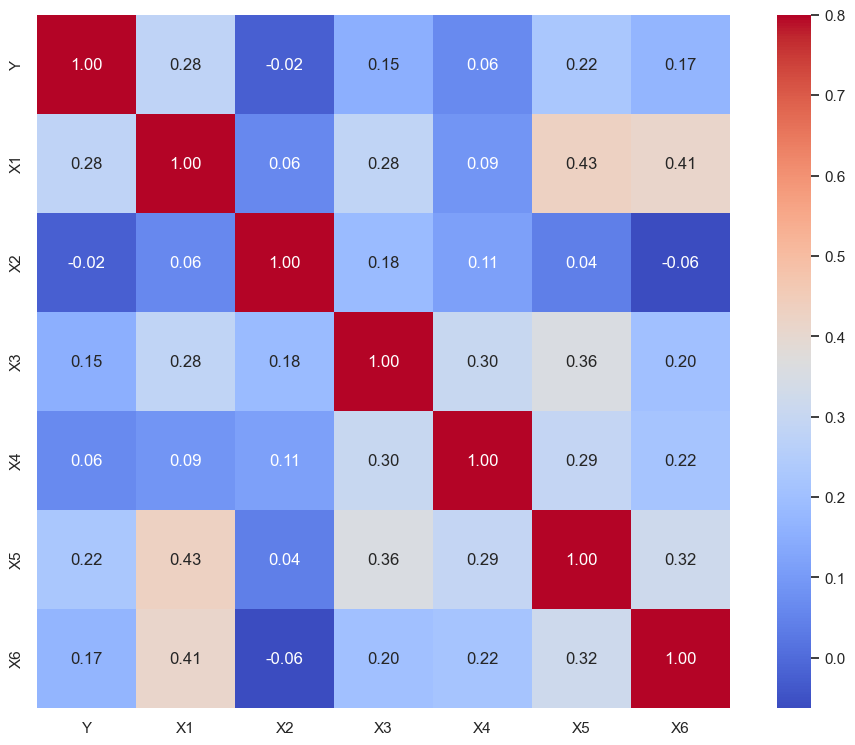

In [32]:
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True, annot=True, fmt='.2f', cmap='coolwarm')


In [33]:
#correlation with the target
corrmat['Y'].sort_values(ascending=False)

Y     1.000000
X1    0.280160
X5    0.224522
X6    0.167669
X3    0.150838
X4    0.064415
X2   -0.024274
Name: Y, dtype: float64

As we can see, none of the variables are strong correlated with the target variable. We can also see that the is some good correlation between the variables X1 and X5 (0.43), and X1 and X6 (0.41).

It makes sense that X1 and X5 are well correlated, because X1 express that the order was delivered on time and X5 express that the customer is satisfied with the courier. X5 is a direct consequence of X1, so it makes sense that they are correlated.

Althoug, it is not clear why X1 and X6 are correlated. Maybe the app makes ordering easy for the customer because the order was delivered on time, or maybe the customer is satisfied with the courier because the app makes ordering easy for the customer.

Either way, we will not drop any of the features because of the correlation or turn 2 into 1 feature yet, as they are not strongly correlated.

In [34]:
#colinearity check with VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X = add_constant(df.drop('Y', axis=1))
pd.Series([variance_inflation_factor(X.values, i)
            for i in range(X.shape[1])],
            index=X.columns)



const    56.076264
X1        1.421675
X2        1.058062
X3        1.274234
X4        1.194403
X5        1.419828
X6        1.293416
dtype: float64

No multcolianerty problems as the values are under 5.

## 1.4 Scatter plot 

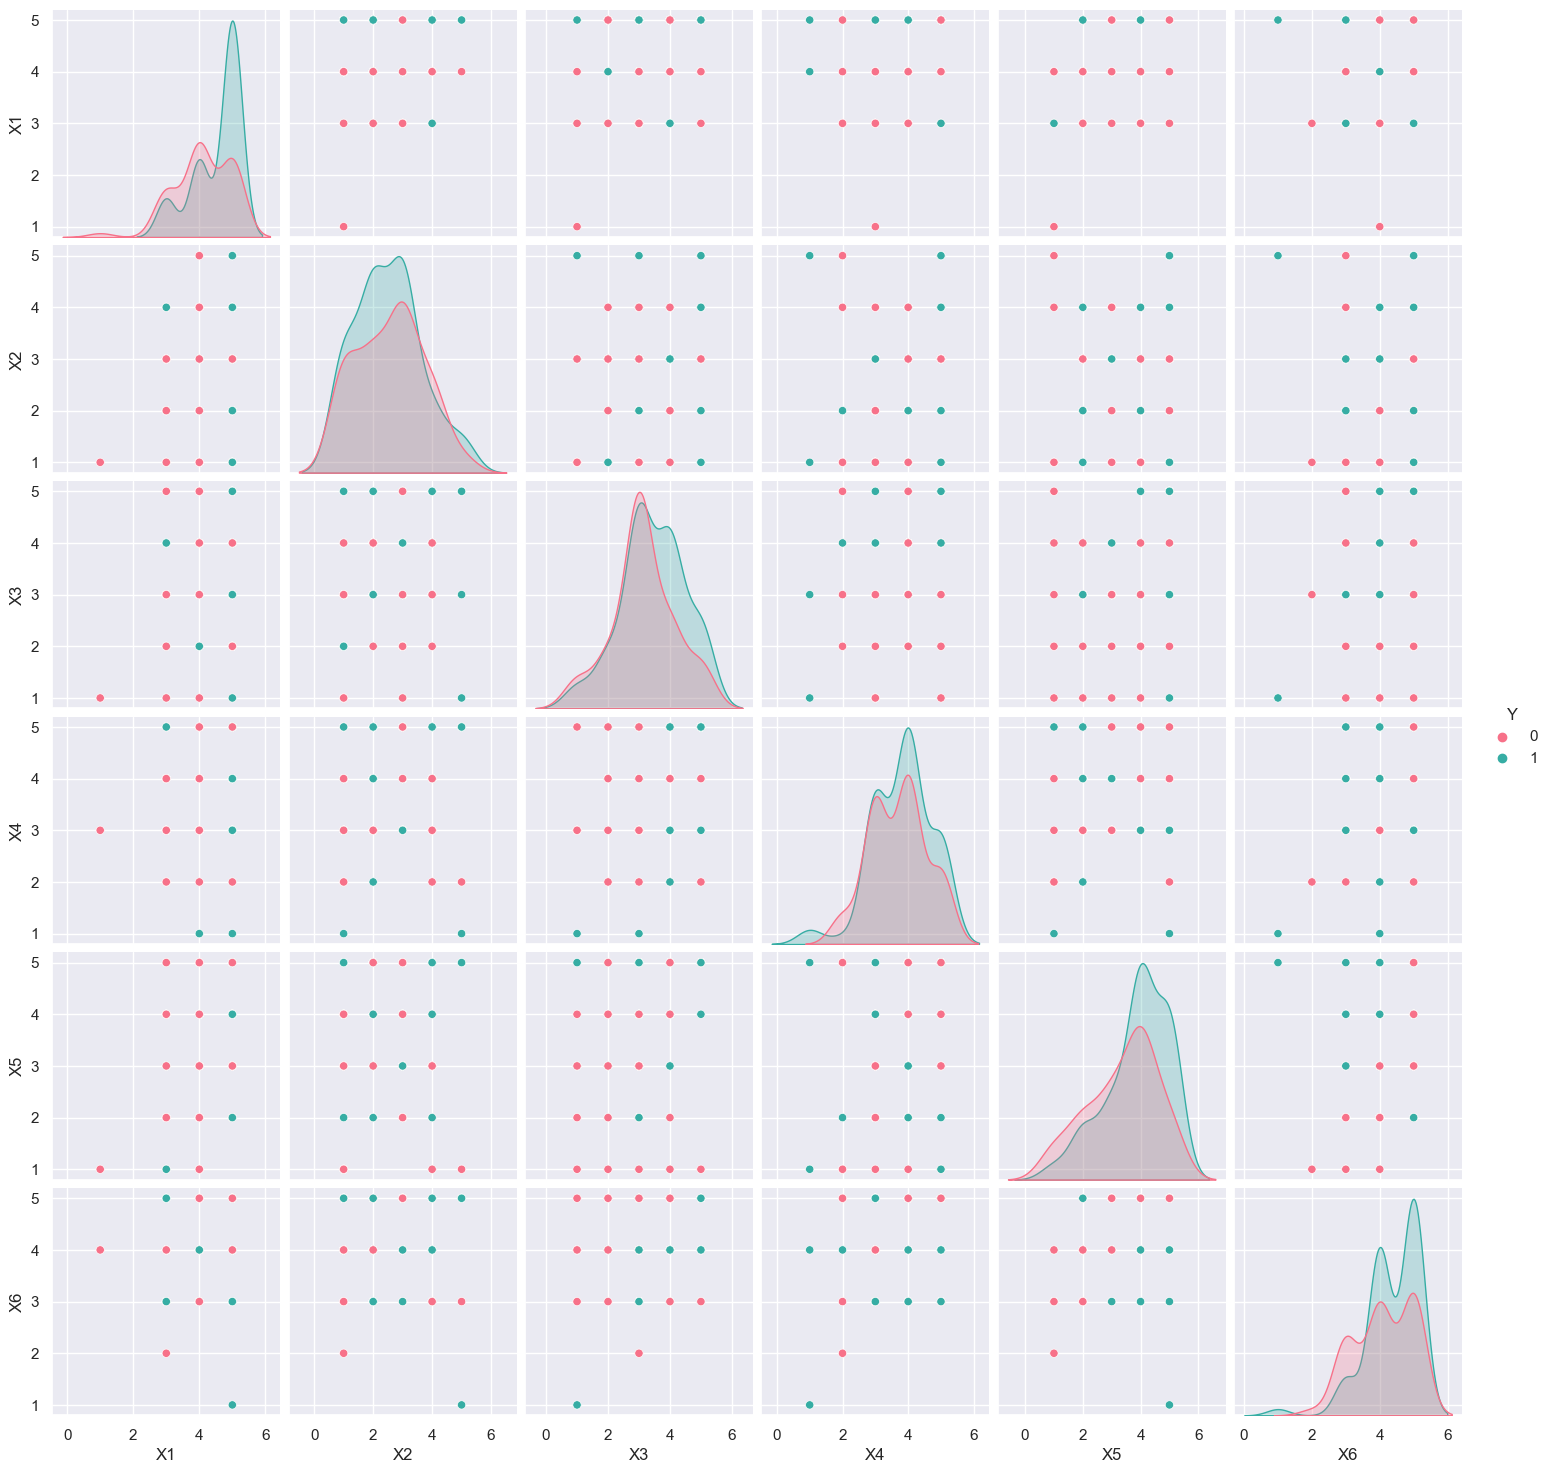

In [35]:
sns.set()
sns.pairplot(df, hue='Y', height=2.5, hue_order=[0, 1], palette='husl', diag_kind='kde')
plt.show()

As we saw in the heat map, there are not obvious relationships between the features and the target variable. We can also see that there are not obvious relationships between the features.

We can also see that the values of X1 that are equals to 3, 4 or 5 results in a target variable equals to 1. 


## 1.5 Conclusion of inicial data analysis

* The data is balanced
* There are no missing values
* There are outliers
* The data has the expected range
* There is no strong correlation between the features as well as the target variable
* X4 and X2 correlation with the target is almost zero
* X5 and X1 have good correlation and one is a direct consequence of the other
* Values of X1 that are equals to 3, 4 or 5 results in a target variable equals to 1
* Values of X5 that are equals to 4 or 5 results in a target variable equals to 1
* Values of X6 that are equals to 4 or 5 results in a target variable equals to 1

# 2 Development of a database

##  Base data version 1.0  - Excluding outliers


Separating our feature set of our target variable:

As we could already see, we will just need to remove the outliers.

* col X1 = 1
* col X2 = 5
* col X3 = 1
* col X4 = 1
* col X5 = 1
* col X6 = 1, 2


In [36]:
df_v1 = df.copy()

df_v1 = df_v1[df_v1['X1'] != 1]
df_v1 = df_v1[df_v1['X2'] != 5]
df_v1 = df_v1[df_v1['X3'] != 1]
df_v1 = df_v1[df_v1['X4'] != 1]
df_v1 = df_v1[df_v1['X5'] != 1]
df_v1 = df_v1[df_v1['X6'] != 1]
df_v1 = df_v1[df_v1['X6'] != 2]


In [37]:
print('% excluded: {:.2f}%'.format((1 - len(df_v1) / len(df)) * 100))

% excluded: 13.49%


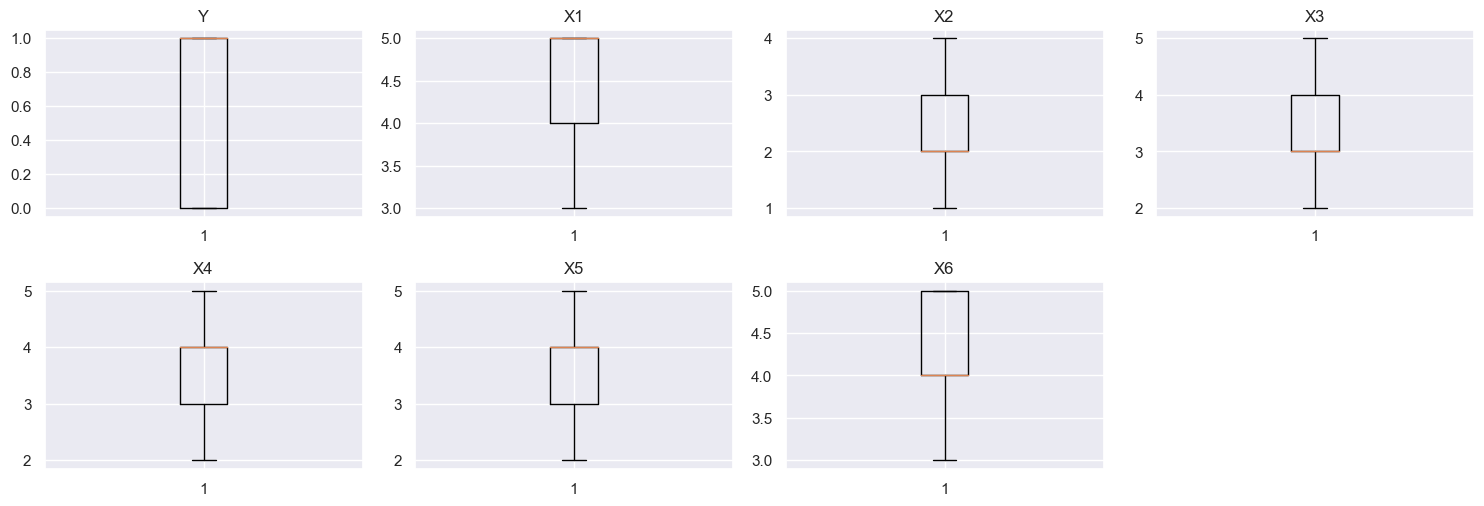

In [38]:
# checking trough the boxplots
plt.figure(figsize=(15,10))

for i, col in enumerate(df_v1.columns):
    plt.subplot(4, 4, i+1, title=col)
    plt.boxplot(df_v1[col])
    plt.tight_layout()

In [39]:
#saving the data to a new csv file

df_v1.to_csv('../data/processed/base_v1.csv', index=False)

In [40]:
#loading the new data
df_v1 = pd.read_csv('../data/processed/base_v1.csv', sep=',')

##  Base data version 2  - non-correlated features

In [41]:
df_v2 = df_v1.copy()
df_v2 = df_v2.drop(['X2', 'X4'], axis=1)
df_v2.to_csv('../data/base_v2.csv', index=False)
df_v2.shape

(109, 5)

##  Base data version 3  - Feature Engineering part 1

* Values of X1 that are equals to 3, 4 or 5 results in a target variable equals to 1
* Values of X5 that are equals to 4 or 5 results in a target variable equals to 1
* Values of X6 that are equals to 4 or 5 results in a target variable equals to 1

In [42]:
df_v3 = df_v1.copy()



In [43]:
#subbing the values of X1 for 3
df_v3['X1'] = np.where(np.isin(df_v3['X1'], [3, 4, 5]), 3, df_v3['X1'])

#subbing the values of X5 for 4
df_v3['X5'] = np.where(np.isin(df_v3['X5'], [4, 5]), 4, df_v3['X5'])

#subbing the values of X6 for 4
df_v3['X6'] = np.where(np.isin(df_v3['X6'], [4, 5]), 4, df_v3['X6'])

In [44]:
#saving the data to a new csv file
df_v3.to_csv('../data/processed/base_v3.csv', index=False)

In [45]:
df_v3

,Y,X1,X2,X3,X4,X5,X6
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,3,3,3,3,3,4
3,0,3,4,3,3,3,4
4,0,3,4,3,3,3,4
...,...,...,...,...,...,...,...
104,1,3,2,3,4,4,3
105,1,3,2,3,4,2,4
106,1,3,3,3,4,4,4
107,0,3,3,3,4,4,4


##  Base data version 4  - Feature Engineering part 2

Getting rid of the correlated features to X1,  X5

In [46]:
df_v4 = df_v1.copy()

In [47]:
df_v4 = df_v4.drop('X5', axis=1)

In [49]:
df_v4.to_csv('../data/processed/base_v4.csv', index=False)

##  Base data version 5  - Feature Engineering part 3

making x1 and x5 the same feature

In [ ]:
import math
df_v5 = df_v1.copy()

In [ ]:
df_v5['X7'] = (df_v5['X1']*df_v5['X2'])/5
df_v5['X7'] = df_v5['X7'].apply(lambda x: round(x)) # get the nereast integer
df_v5.drop(['X1', 'X5'], axis=1, inplace=True)
df_v5.head()

,Y,X2,X3,X4,X6,X7
0,0,3,3,4,4,2
1,0,2,3,5,3,1
2,1,3,3,3,5,3
3,0,4,3,3,5,4
4,0,4,3,3,5,4


In [ ]:
#saving the data to a new csv file
df_v5.to_csv('../data/processed/base_v5.csv', index=False)

##  Base data v6.*: without  a feature

In [ ]:
df = df_v1.copy()
for i in range(1, 7):
    feature = 'X{}'.format(i)
    temp = df.drop(feature, axis=1)
    temp.to_csv('../data/processed/base_v6_{}.csv'.format(feature), index=False)
    

##  Base data v6.2: without  a feature and without X4

In [ ]:
df = pd.read_csv('../data/base_v6_X4.csv', sep=',')
range_1 = [1, 2, 3, 5, 6]

for i in range_1:
    feature = 'X{}'.format(i)
    temp = df.drop(feature, axis=1)
    temp.to_csv('../data/processed/base_v6_X4_{}.csv'.format(feature), index=False)

##  Base data v7: Combinations of the best data versions, the 5 and 6_x4

In [ ]:
df = pd.read_csv('../data/base_v6_X4.csv', sep=',')

df['X7'] = (df['X1']*df['X2'])/5
df['X7'] = df['X7'].apply(lambda x: round(x)) # get the nereast integer
df.drop(['X1', 'X5'], axis=1, inplace=True)

df.to_csv('../data/processed/base_v7.csv', index=False)


